# Visualize CMIP6 model trend variability data

__Figure 2: TTE "true" and "mean" for all obs. and model products Figure__  

(a) Show regional time-to-emergence without observational uncertainty  

(b) Show the “true” time-to-emergence.

(c) Have an easy comparison between regions, and data sources.

Figure written description.

x-axis: IPCC region.

y-axis: TTE "true" and "mean" (slightly shifted from each other on the x-axis).

Symbols and colors will denote the different observational and model products.

## Code

In [26]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

from functions import to_png

%matplotlib inline

### Load processed trend data

#### Models

In [5]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [13]:
cesm1_trends_filepath   = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_trends_filepath     = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_trends_filepath = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_trends_filepath   = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [16]:
cesm1_pic_trends_all   = xr.open_dataarray(*cesm1_trends_filepath)

mpi_pic_trends_all     = xr.open_dataarray(*mpi_trends_filepath)

canesm2_pic_trends_all = xr.open_dataarray(*canesm2_trends_filepath)

esm2m_pic_trends_all   = xr.open_dataarray(*esm2m_trends_filepath)

#### Observations

In [19]:
obs_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'

In [20]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'

In [21]:
gistemp_5x5_trends_filepath  = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_trends_filepath     = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load the trend data

In [22]:
gistemp_5x5_trends_all  = xr.open_dataarray(*gistemp_5x5_trends_filepath)

hadcrut5_trends_all     = xr.open_dataarray(*hadcrut5_trends_filepath)

### Define functions

In [23]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [24]:
def percentile_vec(data,core_dim:str,q,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

### Plot ideas!

Figure written description.

x-axis: IPCC region.

y-axis: TTE "true" and "mean" (slightly shifted from each other on the x-axis).

Symbols and colors will denote the different observational and model products.

## Compute time-to-emergence and observational delay

Calculate a 95% confidence interval on the PI-Control trends.

In [27]:
# CESM1
cesm1_pic_trends_2_5perc  = percentile_vec(cesm1_pic_trends_all,q=2.5,core_dim='startyear').compute()
cesm1_pic_trends_97_5perc = percentile_vec(cesm1_pic_trends_all,q=97.5,core_dim='startyear').compute()

# MPI-GE
mpi_pic_trends_2_5perc  = percentile_vec(mpi_pic_trends_all,q=2.5,core_dim='startyear').compute()
mpi_pic_trends_97_5perc = percentile_vec(mpi_pic_trends_all,q=97.5,core_dim='startyear').compute()

# CanESM2
canesm2_pic_trends_2_5perc  = percentile_vec(canesm2_pic_trends_all,q=2.5,core_dim='startyear').compute()
canesm2_pic_trends_97_5perc = percentile_vec(canesm2_pic_trends_all,q=97.5,core_dim='startyear').compute()

# ESM2M
esm2m_pic_trends_2_5perc  = percentile_vec(esm2m_pic_trends_all,q=2.5,core_dim='startyear').compute()
esm2m_pic_trends_97_5perc = percentile_vec(esm2m_pic_trends_all,q=97.5,core_dim='startyear').compute()

Observational Uncertainty

In [28]:
gistemp_5x5_trends_1960 = gistemp_5x5_trends_all.sel(startyear=1960)
hadcrut5_trends_1960    = hadcrut5_trends_all.sel(startyear=1960)

In [29]:
# Compute the low and high bounds on the trends from the observational products

# GISTEMP 5x5
gistemp_5x5_trends_2_5perc  = percentile_vec(gistemp_5x5_trends_1960,q=2.5,core_dim='record')
gistemp_5x5_trends_50perc  = percentile_vec(gistemp_5x5_trends_1960,q=50,core_dim='record')
gistemp_5x5_trends_97_5perc = percentile_vec(gistemp_5x5_trends_1960,q=97.5,core_dim='record')

# HadCRUT5
hadcrut5_trends_2_5perc  = percentile_vec(hadcrut5_trends_1960,q=2.5,core_dim='realization')
hadcrut5_trends_50perc  = percentile_vec(hadcrut5_trends_1960,q=50,core_dim='realization')
hadcrut5_trends_97_5perc = percentile_vec(hadcrut5_trends_1960,q=97.5,core_dim='realization')

### Compute TTE generally

I should be able to classify the delays in regions which haven't "truly" emerged using inequalities. i.e. obs-delay > 10 years

In [37]:
# Use nested dictionaries to order the data

model_trends_dict = {}

model_trends_dict['CESM1']   = {'2.5':cesm1_pic_trends_2_5perc,'97.5':cesm1_pic_trends_97_5perc}
model_trends_dict['MPI-GE']  = {'2.5':mpi_pic_trends_2_5perc,'97.5':mpi_pic_trends_97_5perc}
model_trends_dict['CanESM2'] = {'2.5':canesm2_pic_trends_2_5perc,'97.5':canesm2_pic_trends_97_5perc}
model_trends_dict['ESM2M']   = {'2.5':esm2m_pic_trends_2_5perc,'97.5':esm2m_pic_trends_97_5perc}

obs_trends_dict = {}

obs_trends_dict['GISTEMP_5x5'] = {'2.5':gistemp_5x5_trends_2_5perc,'50.0':gistemp_5x5_trends_50perc,'97.5':gistemp_5x5_trends_97_5perc}
obs_trends_dict['HadCRUT5_5x5'] = {'2.5':hadcrut5_trends_2_5perc,'50.0':hadcrut5_trends_50perc,'97.5':hadcrut5_trends_97_5perc}

In [59]:
def compute_tte(obs_trends,pic_trends):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    _tte_bool = obs_trends > pic_trends
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=2020,np.nan) # Mask the unemerged regions
    
    return _tte
    
    # mean_tte_bool = gistemp_5x5_trends_50perc > cesm1_pic_trends_97_5perc
    # mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
    # mean_tte      = mean_tte.where(mean_tte!=2020,np.nan) # Mask the unemerged regions
    
    # return _tte

In [54]:
def compute_tte2(obs_trends_high,obs_trends_low,pic_trends_high,pic_trends_low):
    '''
    More general function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    # _tte_bool = obs_trends > pic_trends
    _tte_bool = np.bitwise_or(obs_trends_low > pic_trends_high,obs_trends_high < pic_trends_low)
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=2020,np.nan) # Mask the unemerged regions
    
    return _tte
    
    # mean_tte_bool = gistemp_5x5_trends_50perc > cesm1_pic_trends_97_5perc
    # mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
    # mean_tte      = mean_tte.where(mean_tte!=2020,np.nan) # Mask the unemerged regions
    
    # return _tte

In [43]:
test_out = compute_tte(gistemp_5x5_trends_50perc,cesm1_pic_trends_97_5perc)

In [49]:
test_out2 = compute_tte(gistemp_5x5_trends_2_5perc,cesm1_pic_trends_97_5perc).compute()

In [44]:
test22 = test_out.compute()

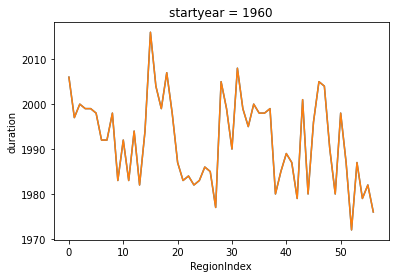

In [48]:
mean_tte.plot()

test22.plot()

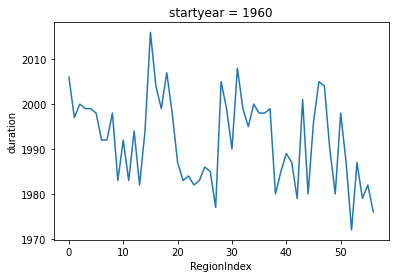

In [66]:
final_tte_dict['CESM1']['GISTEMP_5x5']['meanTTE'].plot()

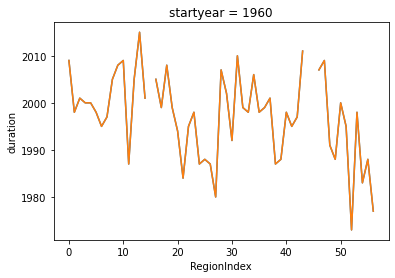

In [50]:
true_tte.plot()

test_out2.plot()

Iterate over the combinations of observational products and model products, computing the "true" and "mean" TTE.

In [77]:
final_tte_list = []

for _model in list(model_trends_dict.keys()):
    print(_model,end=': ')

    obs_product_list = []
    for _obs_prod in list(obs_trends_dict.keys()):
        print(_obs_prod,end=' ')
        
        _true_tte = compute_tte(obs_trends_dict[_obs_prod]['2.5'],model_trends_dict[_model]['97.5']).compute()
        _mean_tte = compute_tte(obs_trends_dict[_obs_prod]['50.0'],model_trends_dict[_model]['97.5']).compute()        
        
        _tte_pack = xr.concat([_mean_tte.assign_coords({'kind':'mean'}).expand_dims('kind',axis=-1),
                               _true_tte.assign_coords({'kind':'true'}).expand_dims('kind',axis=-1)],
                              dim='kind').assign_coords({'obs_prod':_obs_prod}).expand_dims('obs_prod',axis=-1)
        
        obs_product_list.append(_tte_pack)
    
    print('')
    final_tte_list.append(xr.concat(obs_product_list,dim='obs_prod').assign_coords({'model':_model}).expand_dims('model',axis=-1))
    
final_tte_ds = xr.concat(final_tte_list,dim='model')

CESM1: GISTEMP_5x5 HadCRUT5_5x5 
MPI-GE: GISTEMP_5x5 HadCRUT5_5x5 
CanESM2: GISTEMP_5x5 HadCRUT5_5x5 
ESM2M: GISTEMP_5x5 HadCRUT5_5x5 


#### Construct figure.

First (lowest) iteration is over the region.  

Second iteration is over the kind (true vs. mean).  

Then subset by the observational and model products (color and symbol).  

In [83]:
_true_subset

<xarray.DataArray 'duration' (obs_prod: 2, model: 4)>
array([[2009., 2007., 2010., 2010.],
       [2008., 2006., 2010., 2010.]])
Coordinates:
    RegionName    object 'Greenland/Iceland'
    RegionAbbrev  object 'GIC'
    startyear     int64 1960
    kind          <U4 'true'
  * obs_prod      (obs_prod) object 'GISTEMP_5x5' 'HadCRUT5_5x5'
    RegionIndex   int64 0
  * model         (model) object 'CESM1' 'MPI-GE' 'CanESM2' 'ESM2M'

Model:  CESM1 . Obs:  GISTEMP_5x5  TTE:  2006.0
Model:  MPI-GE . Obs:  GISTEMP_5x5  TTE:  2005.0
Model:  CanESM2 . Obs:  GISTEMP_5x5  TTE:  2009.0
Model:  ESM2M . Obs:  GISTEMP_5x5  TTE:  2008.0
Model:  CESM1 . Obs:  HadCRUT5_5x5  TTE:  2006.0
Model:  MPI-GE . Obs:  HadCRUT5_5x5  TTE:  2005.0
Model:  CanESM2 . Obs:  HadCRUT5_5x5  TTE:  2009.0
Model:  ESM2M . Obs:  HadCRUT5_5x5  TTE:  2008.0
Model:  CESM1 . Obs:  GISTEMP_5x5  TTE:  2009.0
Model:  MPI-GE . Obs:  GISTEMP_5x5  TTE:  2007.0
Model:  CanESM2 . Obs:  GISTEMP_5x5  TTE:  2010.0
Model:  ESM2M . Obs:  GISTEMP_5x5  TTE:  2010.0
Model:  CESM1 . Obs:  HadCRUT5_5x5  TTE:  2008.0
Model:  MPI-GE . Obs:  HadCRUT5_5x5  TTE:  2006.0
Model:  CanESM2 . Obs:  HadCRUT5_5x5  TTE:  2010.0
Model:  ESM2M . Obs:  HadCRUT5_5x5  TTE:  2010.0


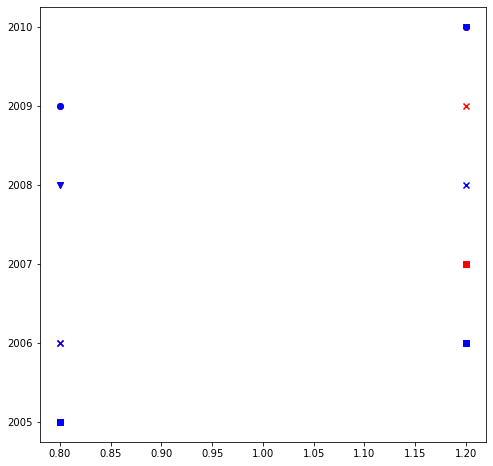

In [94]:
_region_subset = final_tte_ds.sel(RegionIndex=0)

_true_subset = _region_subset.sel(kind='true')
_mean_subset = _region_subset.sel(kind='mean')

# symbols = ['x','$M$','o','$E$']
symbols = ['x','s','o','v']
colors  = ['red','blue']

fig,ax = plt.subplots(1,1,figsize=(8,8))

xstat = 1

for _obs,_color in zip(_mean_subset.obs_prod,colors):
    
    _obs_subset = _mean_subset.sel(obs_prod=_obs)
    
    for _model,_symbol in zip(_obs_subset.model,symbols):
        
        _model_subset = _obs_subset.sel(model=_model)
        
        print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
        
        ax.scatter(xstat-0.2,_model_subset,marker=_symbol,c=_color)

for _obs,_color in zip(_true_subset.obs_prod,colors):
    
    _obs_subset = _true_subset.sel(obs_prod=_obs)
    
    for _model,_symbol in zip(_obs_subset.model,symbols):
        
        _model_subset = _obs_subset.sel(model=_model)
        
        print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
        
        ax.scatter(xstat+0.2,_model_subset,marker=_symbol,c=_color)
        

# ax.scatter(

The mean TTE is agreed upon, which makes sense because the observational products have very similar means. The red obs product seems to be delaying more than the blue product?

Color is the observational product. 

Symbol is the model used to generate the PIC variability.

Seems to be an issue that things are right on top of each other...

#### Plots for all regions.

I should figure out how to show when a model-obs combination does not show emergence. i.e. Create a ghost symbol somewhere in the appropriate figure column.

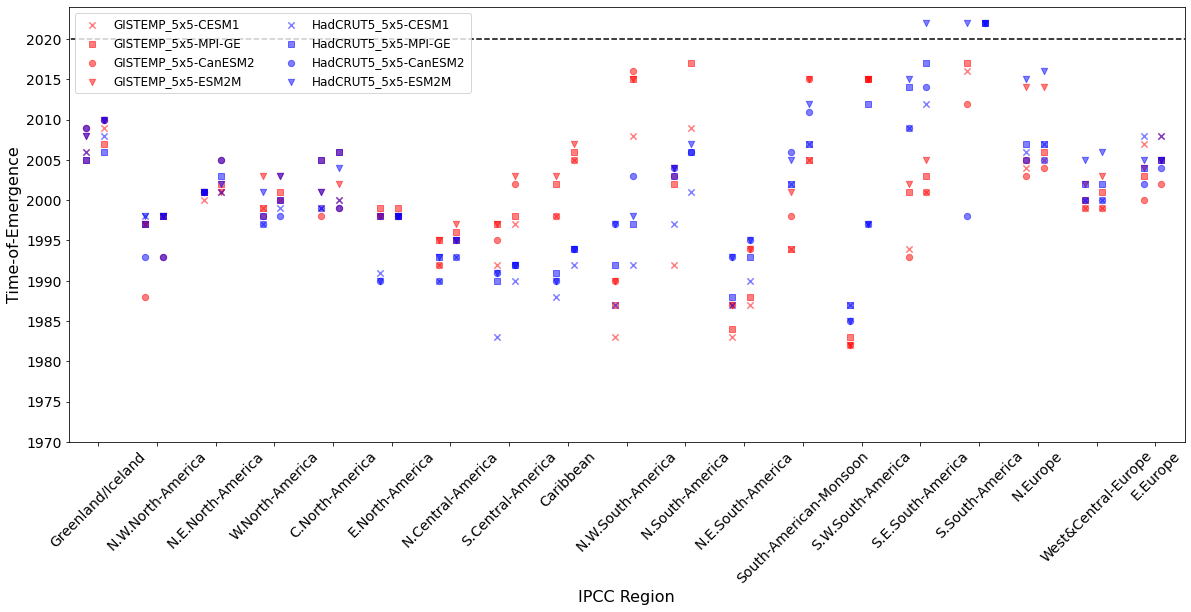

In [167]:
# symbols = ['x','$M$','o','$E$']
symbols = ['x','s','o','v']
colors  = ['red','blue']

fig,ax = plt.subplots(1,1,figsize=(20,8))

start_idx = 0
stop_idx  = 18

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []
for _index,_label in zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName):
    xstat = _index
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _true_subset = _region_subset.sel(kind='true')
    _mean_subset = _region_subset.sel(kind='mean')    

    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)

            ax.scatter(xstat-0.2,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)

            ax.scatter(xstat+0.1,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)
        

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        ax.scatter(None,None,marker=_symbol,c=_color,alpha=0.5,s=40,label='%s-%s' % (_obs.values,_model.values))
        
ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
        
ax.set_xlabel('IPCC Region',fontsize=16)
ax.set_ylabel('Time-of-Emergence',fontsize=16)
ax.set_xticks(np.arange(start_idx,stop_idx+1))
ax.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax.set_yticks(np.arange(1970,2021,5))
ax.set_xlim(start_idx-0.5,stop_idx+0.5)
ax.set_ylim(1970,2024)
ax.tick_params(axis='both',labelsize=14)

ax.legend(ncol=2,loc='best',fontsize=12)
# ax.legend(ncol=2,loc='upper right',fontsize=12)

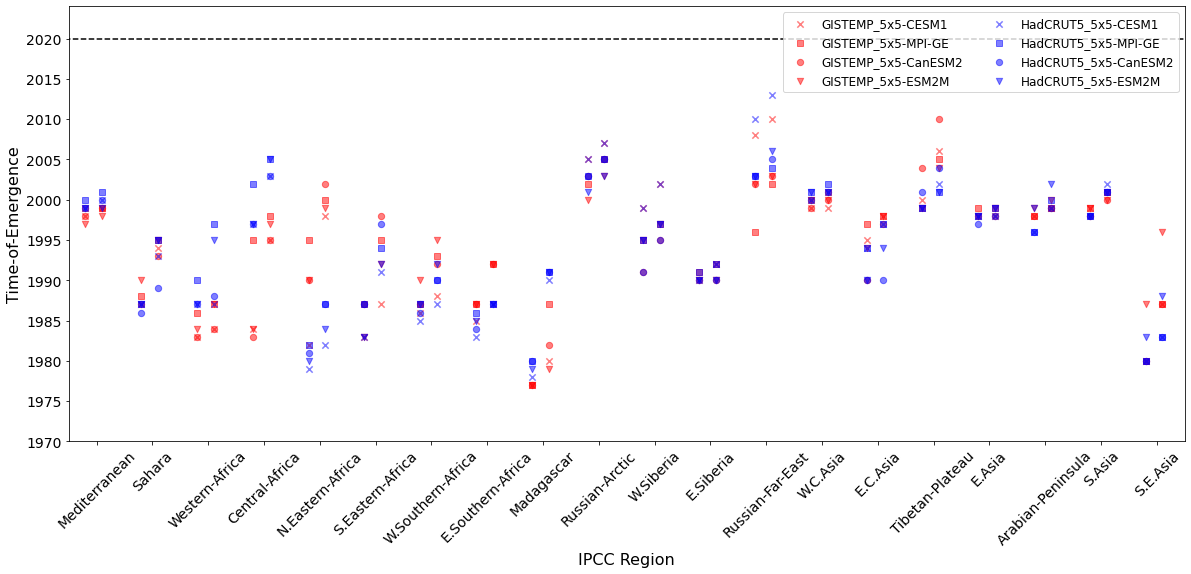

In [163]:
# symbols = ['x','$M$','o','$E$']
symbols = ['x','s','o','v']
colors  = ['red','blue']

fig,ax = plt.subplots(1,1,figsize=(20,8))

start_idx = 19
stop_idx  = 38

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []
for _index,_label in zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName):
    xstat = _index
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _true_subset = _region_subset.sel(kind='true')
    _mean_subset = _region_subset.sel(kind='mean')    

    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)

            ax.scatter(xstat-0.2,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)

            ax.scatter(xstat+0.1,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)
        

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        ax.scatter(None,None,marker=_symbol,c=_color,alpha=0.5,s=40,label='%s-%s' % (_obs.values,_model.values))
        
ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
        
ax.set_xlabel('IPCC Region',fontsize=16)
ax.set_ylabel('Time-of-Emergence',fontsize=16)
ax.set_xticks(np.arange(start_idx,stop_idx+1))
ax.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax.set_yticks(np.arange(1970,2021,5))
ax.set_xlim(start_idx-0.5,stop_idx+0.5)
ax.set_ylim(1970,2024)
ax.tick_params(axis='both',labelsize=14)

ax.legend(ncol=2,loc='best',fontsize=12)
# ax.legend(ncol=2,loc='upper right',fontsize=12)

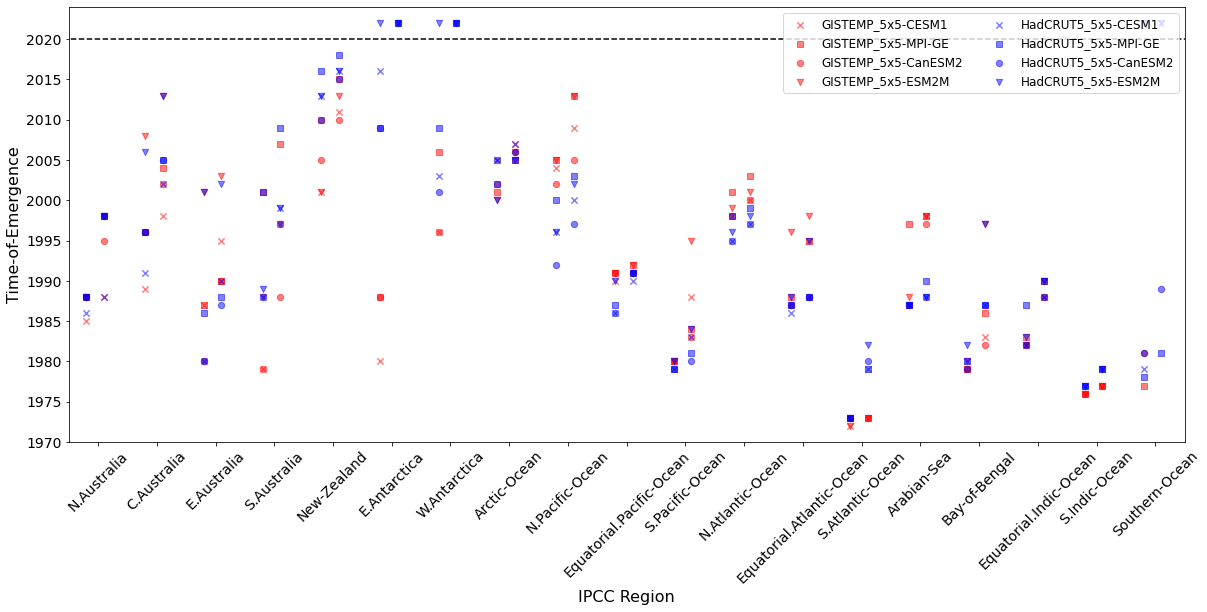

In [162]:
# symbols = ['x','$M$','o','$E$']
symbols = ['x','s','o','v']
colors  = ['red','blue']

fig,ax = plt.subplots(1,1,figsize=(20,8))

start_idx = 39
stop_idx  = 57

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []
for _index,_label in zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName):
    xstat = _index
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _true_subset = _region_subset.sel(kind='true')
    _mean_subset = _region_subset.sel(kind='mean')    

    for _obs,_color in zip(_mean_subset.obs_prod,colors):

        _obs_subset = _mean_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)

            ax.scatter(xstat-0.2,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)

    for _obs,_color in zip(_true_subset.obs_prod,colors):

        _obs_subset = _true_subset.sel(obs_prod=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)

            # ax.scatter(xstat+0.1,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)
        
            if np.isnan(_model_subset):
                pass
                # ax.scatter(xstat+0.1,2021,marker=_symbol,c=_color,alpha=0.5,s=40)
            else:
                ax.scatter(xstat+0.1,_model_subset,marker=_symbol,c=_color,alpha=0.5,s=40)

# Prep legend with fake plots.
for _obs,_color in zip(_true_subset.obs_prod,colors):

    _obs_subset = _true_subset.sel(obs_prod=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        ax.scatter(None,None,marker=_symbol,c=_color,alpha=0.5,s=40,label='%s-%s' % (_obs.values,_model.values))

ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
        
ax.set_xlabel('IPCC Region',fontsize=16)
ax.set_ylabel('Time-of-Emergence',fontsize=16)
ax.set_xticks(np.arange(start_idx,stop_idx+1))
ax.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax.set_yticks(np.arange(1970,2021,5))
ax.set_xlim(start_idx-0.5,stop_idx+0.5)
ax.set_ylim(1970,2024)
ax.tick_params(axis='both',labelsize=14)

ax.legend(ncol=2,loc='best',fontsize=12)
# ax.legend(ncol=2,loc='upper right',fontsize=12)

Ok, there appear to be some issues here with how I am defining time-of-emergence. Because nothing should be later than 2020.

In [31]:
# If the duration with the last "False" is 3, then we needed to observe for 4 years for the signal to emerge. 
# Then the signal emerged at the end of the fourth year 1963 or the beginning of the 5th year (1964).
# So I add 1960 to the duration of the last "False" and we report the year when the signal emerged. i.e. If we had stopped measuring then it would be emerged.

mean_tte_bool = gistemp_5x5_trends_50perc > cesm1_pic_trends_97_5perc
mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
mean_tte      = mean_tte.where(mean_tte!=2020,np.nan) # Mask the unemerged regions

true_tte_bool = gistemp_5x5_trends_2_5perc > cesm1_pic_trends_97_5perc
true_tte      = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')
true_tte      = true_tte.where(true_tte!=2020,np.nan) # Mask the unemerged regions

Package different data products and then iterate over each to appropriately pair and save them.

In [33]:
ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

# unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
unc_mask = ipcc_ar6_regions_all.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

# CESM1-GISTEMP 5x5
cesm1_gistemp_5x5_mean_mask = unc_mask.copy()
cesm1_gistemp_5x5_true_mask = unc_mask.copy()

del unc_mask

for i in ipcc_ar6_regions_all.numbers:
    
    cesm1_gistemp_5x5_mean_mask = xr.where(cesm1_gistemp_5x5_mean_mask==i,mean_tte.sel(RegionIndex=i),cesm1_gistemp_5x5_mean_mask)
    cesm1_gistemp_5x5_true_mask = xr.where(cesm1_gistemp_5x5_true_mask==i,true_tte.sel(RegionIndex=i),cesm1_gistemp_5x5_true_mask)

cesm1_gistemp_5x5_tte_ukn_mask = np.bitwise_and(np.isnan(cesm1_gistemp_5x5_true_mask),~np.isnan(cesm1_gistemp_5x5_mean_mask.values))
cesm1_gistemp_5x5_delay_ukn_mask = (2020 - cesm1_gistemp_5x5_mean_mask).where(cesm1_gistemp_5x5_tte_ukn_mask) # Calculate the minimum observational delay

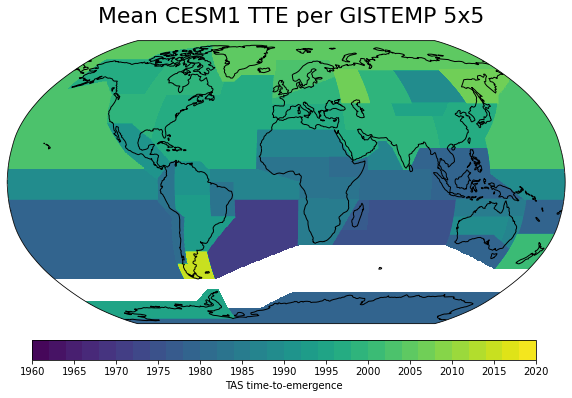

In [34]:
model_name = 'Mean CESM1 TTE per GISTEMP 5x5'
_unc_mask = cesm1_gistemp_5x5_mean_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(1960,2020,31))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(1960,2020,13),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

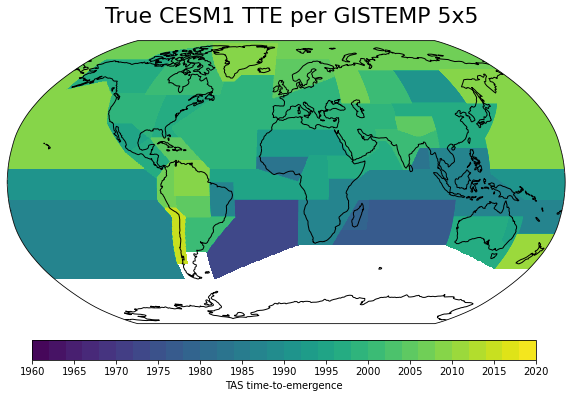

In [35]:
model_name = 'True CESM1 TTE per GISTEMP 5x5'
_unc_mask = cesm1_gistemp_5x5_true_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(1960,2020,31))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(1960,2020,13),
             label='TAS time-to-emergence',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

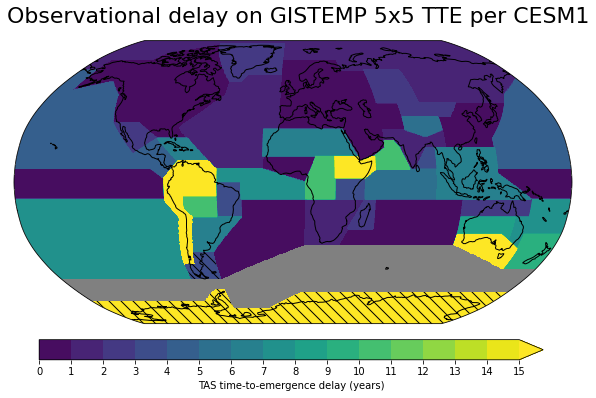

In [36]:
model_name = 'Observational delay on GISTEMP 5x5 TTE per CESM1'
_unc_mask = (cesm1_gistemp_5x5_true_mask - cesm1_gistemp_5x5_mean_mask)
_unc_mask2 = cesm1_gistemp_5x5_delay_ukn_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask,
                 transform=ccrs.PlateCarree(),levels=np.linspace(0,15,16),
                 extend='max',
                ) # np.linspace(0,30,31)

im2 = ax.contourf(_unc_mask2.lon,_unc_mask2.lat,_unc_mask2,
                  transform=ccrs.PlateCarree(),levels=np.linspace(0,15,16),
                  extend='max',
                 )
hat = ax.contourf(_unc_mask2.lon,_unc_mask2.lat,_unc_mask2, levels=[0,2,41], colors='none',
                  transform=ccrs.PlateCarree(),
                  hatches=[None,'\\\\',],
                  extend='max')

no_meanemerge_mask = np.isnan(cesm1_gistemp_5x5_mean_mask).where(np.isnan(cesm1_gistemp_5x5_mean_mask))
grey = ax.contourf(no_meanemerge_mask.lon,no_meanemerge_mask.lat,no_meanemerge_mask,
                   transform=ccrs.PlateCarree(),
                   extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                  )
ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,15,16),   # np.linspace(0,30,31)
             label='TAS time-to-emergence delay (years)',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

#### To-do's:

- Put these panels together.

- Look at the ratio of internal variability to observational uncertainty. The northern hemisphere emerges later because of the higher internal variability, but the observational delay is also shorter because the internal variability is so large.

- The above argument explains most of the delay, but not all of it. This is how we get to cases where the assumptions of Weatherhead/Leroy break down. Specifically, a. trends on non-linear and b. the observational uncertainty does not average down as expected due to the loss of stations, etc.

#### Re-order panels

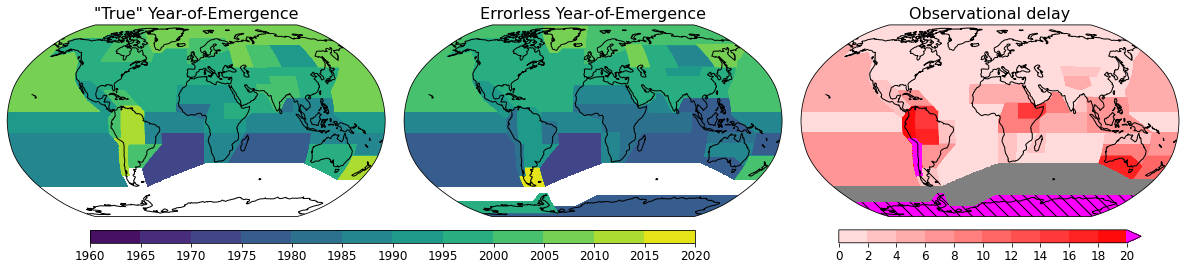

In [23]:
fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
axs = axs.flat

cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
delay_cmap.set_over('magenta')
delay_mask = cesm1_gistemp_2x2_delay_ukn_mask
delay_levels = list(np.linspace(0,20,11))
# masks      = [cesm1_gistemp_2x2_mean_mask,cesm1_gistemp_2x2_true_mask,(cesm1_gistemp_2x2_true_mask - cesm1_gistemp_2x2_mean_mask)]
# titles = ['Errorless Year-of-Emergence','"True" Year-of-Emergence','Observational delay']
no_meanemerge_mask = np.isnan(cesm1_gistemp_2x2_mean_mask).where(np.isnan(cesm1_gistemp_2x2_mean_mask))
masks      = [cesm1_gistemp_2x2_true_mask,cesm1_gistemp_2x2_mean_mask,(cesm1_gistemp_2x2_true_mask - cesm1_gistemp_2x2_mean_mask)]
titles = ['"True" Year-of-Emergence','Errorless Year-of-Emergence','Observational delay']
levels = [np.linspace(1960,2020,13),np.linspace(1960,2020,13),delay_levels] 
cmaps = ['viridis','viridis',delay_cmap]
# cmaps = ['viridis','viridis','rocket_r']
extend = ['neither','neither','max']

plt.subplots_adjust(wspace=0.05)

ims = [] 
for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):
    
    im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                      transform=ccrs.PlateCarree(),
                      levels=_levels,
                      cmap=_cmap,
                      extend=_extend,
                     )

    _ax.coastlines()
    _ax.set_global()
    _ax.set_title(_label,fontsize=16)
    
    ims.append(im)

im = axs[2].contourf(delay_mask.lon,delay_mask.lat,delay_mask,
                    transform=ccrs.PlateCarree(),levels=delay_levels,
                    extend='max',cmap=delay_cmap,
                    # extend='max',cmap='rocket_r',
                   )
ims.append(im)

_ = axs[2].contourf(delay_mask.lon,delay_mask.lat,delay_mask, levels=[0,2,41], colors='none',
                    transform=ccrs.PlateCarree(),
                    hatches=[None,'\\\\',],
                    extend='max',
                   )

grey = axs[2].contourf(no_meanemerge_mask.lon,no_meanemerge_mask.lat,no_meanemerge_mask,
                       transform=ccrs.PlateCarree(),
                       extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                      )

cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                     ticks=np.linspace(1960,2020,13),
                     cax=cax1,
                    )

cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                     ticks=np.linspace(0,20,11), # delay_levels, 
                     cax=cax2,
                    )

cbar1.ax.tick_params(labelsize=12) 
cbar2.ax.tick_params(labelsize=12) 
# cbar.set_label('Standard Deviation of 10-year TAS trends',fontsize=12)

plt.show()

In [24]:
# to_png(file=fig,filename='TAS_TTE_delay_CESM1_GISTEMP2x2',dpi=300,ext='pdf',bbox_inches='tight')

### See how much of the observational delay is explained by Leroy 2008

Per Leroy's derivation, time-to-emergence when observational uncertainty is considered is given by:

$$ \Delta t = \bigg[ \frac{12s^2}{m_{est}^2}(\sigma_{var}^2 \tau_{var} + \sigma_{obs}^2 \tau_{obs}) \bigg]^{1/3} $$

We can fiddle with this expression to pull out the fractional delay due to observational uncertainty $(1 + f^2)^{1/3}$:  

$$ \Delta t = \bigg[ \frac{12s^2}{m_{est}^2}(\sigma_{var}^2 \tau_{var}) \bigg]^{1/3} (1 + f^2)^{1/3}, $$

where 

$$ f^2 = \frac{\sigma_{var}^2 \tau_{var}}{\sigma_{obs}^2 \tau_{obs}}. $$

Since, we quantify the uncertainty explicitly, we can't use $\sigma$ and $\tau$. Instead, I will use the explicitly determined observational and climate uncertainty at the "errorless" time-of-emergence. This could be a standard deviation or a 95% confidence interval, both should work fine if things are reasonably gaussian.

__1. Calculate the fractional delay in emergence.__  

__2. Calculate the modified Leroy factor.__

__3. Use a simple regression to see how much of the variance is explained by the ratios of uncertainty.__

__4. Exceptions should be due to departures from Leroy's assumptions: a. AR1 noise, no loss of stations, b. constant trend.__

#### Make it so!

Create a mask to remove regions where both values are not available.

In [25]:
obs_mask = ~np.bitwise_or(np.isnan(mean_tte),np.isnan(true_tte))

__1. Calculate the fractional delay in emergence.__  

In [26]:
fractional_delay = ((true_tte[obs_mask] - mean_tte[obs_mask]) / (mean_tte[obs_mask]-1960)).compute() # normalize to the 1960 start year

__2. Calculate the modified Leroy factor.__

In [27]:
# Use the span of a 95% confidence interval
gistemp_2x2_95CI_span = gistemp_2x2_trends_97_5perc - gistemp_2x2_trends_2_5perc
cesm1_pic_95CI_span = cesm1_pic_trends_97_5perc - cesm1_pic_trends_2_5perc

gistemp_cesm1_unc_ratio = gistemp_2x2_95CI_span / cesm1_pic_95CI_span
gistemp_cesm1_unc_ratio = gistemp_cesm1_unc_ratio[:,obs_mask] # mask missing regions

In [28]:
# Select the ratio at the year of emergence
ratios_at_emerge = []

for i_region in gistemp_cesm1_unc_ratio.RegionIndex:
    # print(i_region)    
    _year_of_emerge = mean_tte.sel(RegionIndex=i_region)
    # print(_year_of_emerge.values)
    # if not np.isnan(_year_of_emerge):
    _ratio_at_emerge = gistemp_cesm1_unc_ratio.sel(RegionIndex=i_region,duration=(_year_of_emerge-1960))
        # print(_ratio_at_emerge.values)

    _ratio = _ratio_at_emerge.drop('duration') # Drop this dimension so we can concatenate along something else
    ratios_at_emerge.append(_ratio)

ratios_at_emerge_ds = xr.concat(ratios_at_emerge,dim='RegionIndex')

In [29]:
leroy_delay_factor = ((1 + ratios_at_emerge_ds)**(1/3)).compute()

__3. Use a simple regression to see how much of the variance is explained by the ratios of uncertainty.__

In [30]:
import scipy.stats as stats

In [92]:
import matplotlib as mpl
import matplotlib.cm as cm

In [31]:
leroy_linregress = stats.linregress(x=leroy_delay_factor,y=fractional_delay)

In [32]:
leroy_linregress

LinregressResult(slope=1.4577681706719505, intercept=-1.4097421408863313, rvalue=0.3883595183975226, pvalue=0.0037088523304936193, stderr=0.47968034072971755)

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

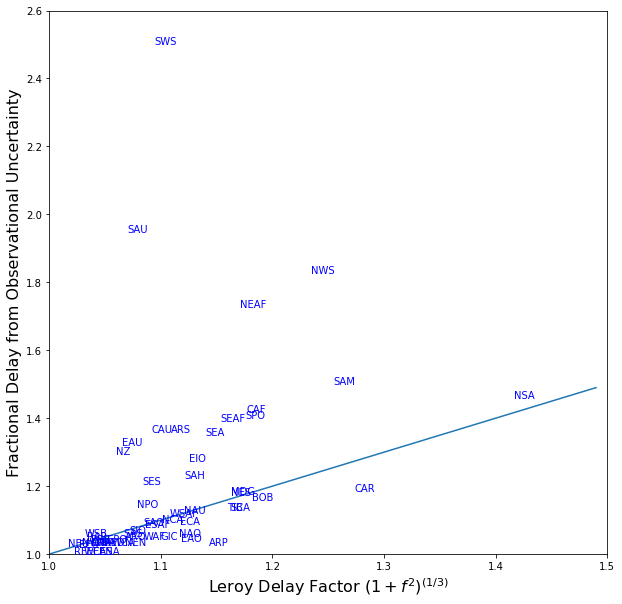

In [33]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionAbbrev.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

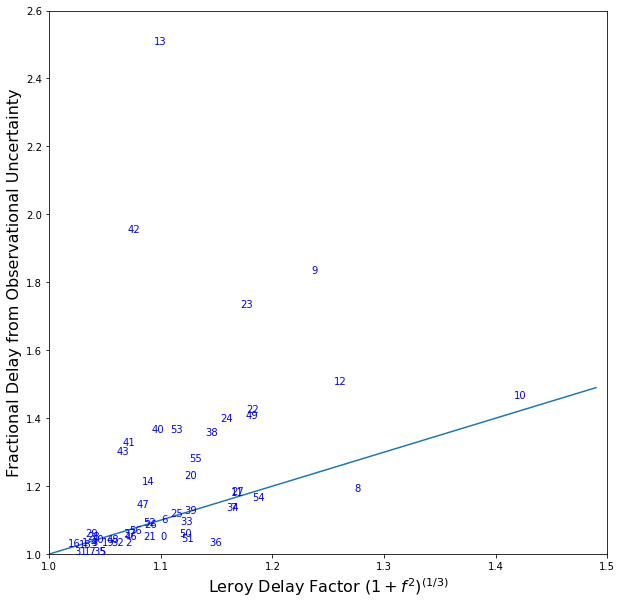

In [34]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionIndex.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

__4. Exceptions should be due to departures from Leroy's assumptions: a. AR1 noise, no loss of stations, b. constant trend.__

__(a) scatter showing 1-1 line, maybe label the interesting crazy outliers__  

- maybe color points in some way based on findings of b and c   
    

__(b) Change in trend after TTE, somehow colored by position relative to 1-1 line__  

- red above 1-1, blue for below 1-1  

__(c) Ratio of sigma_var/sigma_obs after TTE, using same coloring as (b)__

#### Make figure iteratively.

__(a) scatter showing 1-1 line, maybe label the interesting crazy outliers__  

- maybe color points in some way based on findings of b and c   
    

Text(0, 0.5, 'Fractional Delay from Observational Uncertainty')

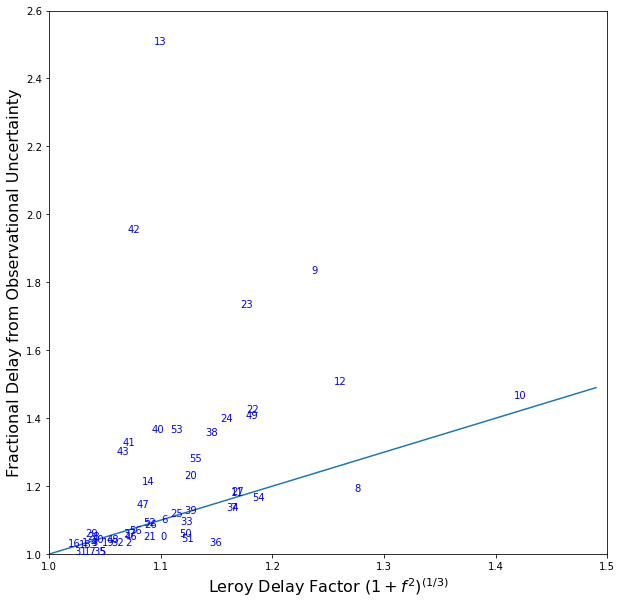

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,10))


for _x,_y in zip(leroy_delay_factor,1+fractional_delay):
    ax.text(_x,_y,str(_x.RegionIndex.values),color='blue')
# ax.scatter(leroy_delay_factor,fractional_delay,
           # marker=list(leroy_delay_factor.RegionAbbrev.values),
          # )

ax.plot(np.arange(1,1.5,0.01),np.arange(1,1.5,0.01))

ax.set_xlim(1,1.5)
ax.set_ylim(1,2.6)

ax.set_xlabel('Leroy Delay Factor $(1+f^2)^{(1/3)}$',fontsize=16)
ax.set_ylabel('Fractional Delay from Observational Uncertainty',fontsize=16)

__(b) Change in trend after TTE, somehow colored by position relative to 1-1 line__  

- red above 1-1, blue for below 1-1  

Is the delay greater than estimated from Leroy?

In [73]:
delay_yrs = (true_tte[obs_mask] - mean_tte[obs_mask]).compute()

In [169]:
delay_yrs

<xarray.DataArray 'duration' (RegionIndex: 54)>
array([ 2.,  1.,  1.,  1.,  1.,  0.,  3.,  4.,  7., 19., 16.,  4., 17.,
       33.,  7.,  1.,  0.,  1.,  1.,  6.,  1., 10., 16.,  9.,  3.,  2.,
        3.,  2.,  2.,  1.,  0.,  1.,  3.,  5.,  0.,  1.,  2.,  7.,  3.,
       10.,  9., 18., 12.,  2.,  6.,  1.,  8.,  2.,  1.,  1., 10.,  3.,
        6.,  1.])
Coordinates:
    startyear     int64 1960
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 50 51 52 53 54 55 56
    RegionName    (RegionIndex) object 'Greenland/Iceland' ... 'S.Indic-Ocean'
    RegionAbbrev  (RegionIndex) object 'GIC' 'NWN' 'NEN' ... 'BOB' 'EIO' 'SIO'

In [171]:
delay_yrs[-13]

<xarray.DataArray 'duration' ()>
array(18.)
Coordinates:
    startyear     int64 1960
    RegionIndex   int64 42
    RegionName    object 'S.Australia'
    RegionAbbrev  object 'SAU'

In [172]:
delay_yrs.RegionName[-13]

<xarray.DataArray 'RegionName' ()>
array('S.Australia', dtype=object)
Coordinates:
    startyear     int64 1960
    RegionIndex   int64 42
    RegionName    object 'S.Australia'
    RegionAbbrev  object 'SAU'

In [36]:
fractional_delay_residual = 1 + fractional_delay - leroy_delay_factor

In [76]:
# Select the trend timeseries starting at the year of emergence
trends_from_emerge = []

for i_region in gistemp_2x2_trends_50perc.RegionIndex:
    # print(i_region)
    
    # if (true_tte.sel(RegionIndex=i_region) != np.nan):
    if (~np.isnan(true_tte.sel(RegionIndex=i_region))):
        _year_of_emerge  = mean_tte.sel(RegionIndex=i_region)
        _delay           = delay_yrs.sel(RegionIndex=i_region)
        _emerge_duration = _year_of_emerge - 1960
        # Old code take all years after emerge
        # _trends_from_emerge = gistemp_2x2_tren÷ds_50perc.sel(RegionIndex=i_region,).sel(duration=slice(_year_of_emerge-1960,None))
        
        # New code take years between mean emerge and true emerge
        _trends_from_emerge = gistemp_2x2_trends_50perc.sel(RegionIndex=i_region,).sel(duration=slice(_emerge_duration,_emerge_duration+_delay))

        # _ratio = _ratio_at_emerge.drop('duration') # Drop this dimension so we can concatenate along something else
        trends_from_emerge.append(_trends_from_emerge.compute())

# ratios_at_emerge_ds = xr.concat(ratios_at_emerge,dim='RegionIndex')

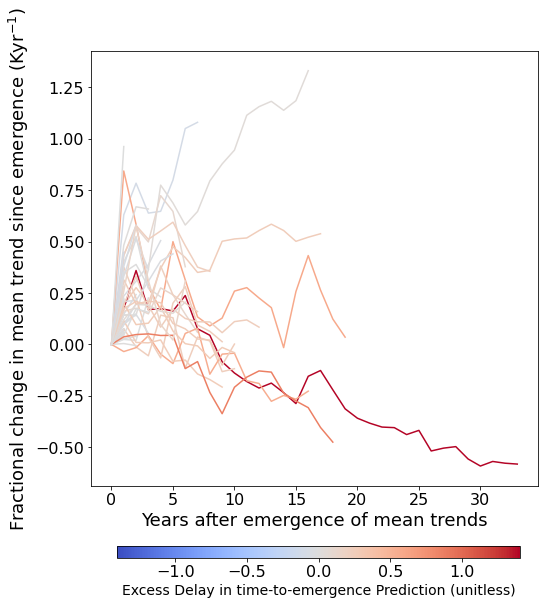

In [153]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _trend_tseries,_delay_resid,_color in zip(trends_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        # ax.plot(_trend_tseries-_trend_tseries[0],color=color)
        ax.plot((_trend_tseries-_trend_tseries[0])/_trend_tseries[0],color=_color)
        
# ax.set_ylabel('Change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_ylabel('Fractional change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])

cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

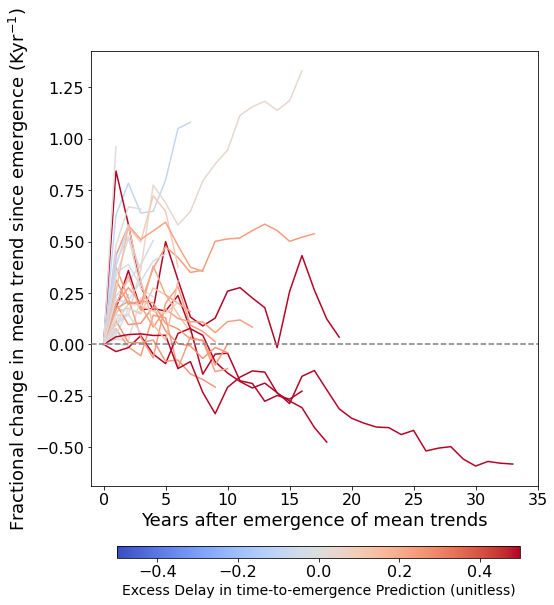

In [161]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

# min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)
min_val, max_val = -0.5, 0.5

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _trend_tseries,_delay_resid,_color in zip(trends_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        # ax.plot(_trend_tseries-_trend_tseries[0],color=color)
        ax.plot((_trend_tseries-_trend_tseries[0])/_trend_tseries[0],color=_color)

ax.hlines(y=0,xmin=-1,xmax=35,color='grey',zorder=100,linestyle='dashed')
        
# ax.set_ylabel('Change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_ylabel('Fractional change in mean trend since emergence (Kyr$^{-1}$)',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.set_xlim(-1,35)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])

cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

Red when the trend emergence is delayed more than expected. Blue when the trend emergence is delayed less than expected.

Not super clear here. But in general the trends that are delayed by less than expected seem to show increasing trends after the emergence of the mean trend (i.e. faster warming). This makes sense, but the picture is far from clear.

__(c) Ratio of sigma_var/sigma_obs after TTE, using same coloring as (b)__

In [80]:
# Select the trend timeseries starting at the year of emergence
ratios_from_emerge = []

for i_region in gistemp_cesm1_unc_ratio.RegionIndex:
    # print(i_region)    
    _year_of_emerge  = mean_tte.sel(RegionIndex=i_region)
    _delay           = delay_yrs.sel(RegionIndex=i_region)
    _emerge_duration = _year_of_emerge - 1960    

    _ratio_from_emerge = gistemp_cesm1_unc_ratio.sel(RegionIndex=i_region,).sel(duration=slice(_emerge_duration,_emerge_duration+_delay))
        # print(_ratio_at_emerge.values)

    # _ratio = _ratio_at_emerge.drop('duration') # Drop this dimension so we can concatenate along something else
    ratios_from_emerge.append(_ratio_from_emerge.compute())

# ratios_at_emerge_ds = xr.concat(ratios_at_emerge,dim='RegionIndex')

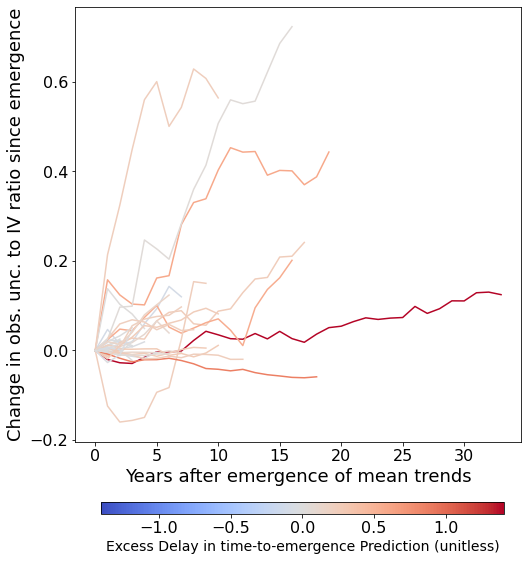

In [143]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _ratio_tseries,_delay_resid,_color in zip(ratios_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        ax.plot(_ratio_tseries-_ratio_tseries[0],color=_color)
        
ax.set_ylabel('Change in obs. unc. to IV ratio since emergence',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])
# cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

# cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

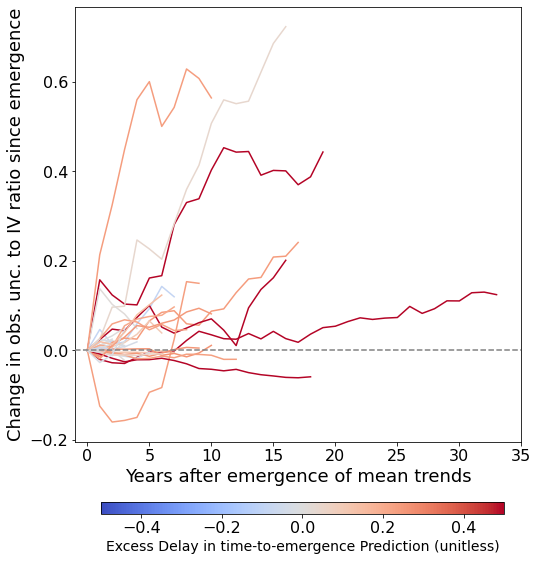

In [162]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

# min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)
min_val, max_val = -0.5, 0.5

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

for _ratio_tseries,_delay_resid,_color in zip(ratios_from_emerge,
                                              fractional_delay_residual,
                                              color_list):
    
    if len(_trend_tseries) > 0:
        ax.plot(_ratio_tseries-_ratio_tseries[0],color=_color)
        
ax.hlines(y=0,xmin=-1,xmax=35,color='grey',zorder=100,linestyle='dashed')

ax.set_ylabel('Change in obs. unc. to IV ratio since emergence',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.set_xlim(-1,35)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])

cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # ticks = sorted(distance_list), 
                               orientation='horizontal')

cb.set_label('Excess Delay in time-to-emergence Prediction (unitless)',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

Again, this is kind of unclear unfortunately. But in general, when the uncertainty ratio increases a lot after the mean emergence, the true delay generally exceeds the expected delay, which makes sense. We see that the uncertainty ratio often stays very similar, but it rarely decreases. 

#### Combine both metrics

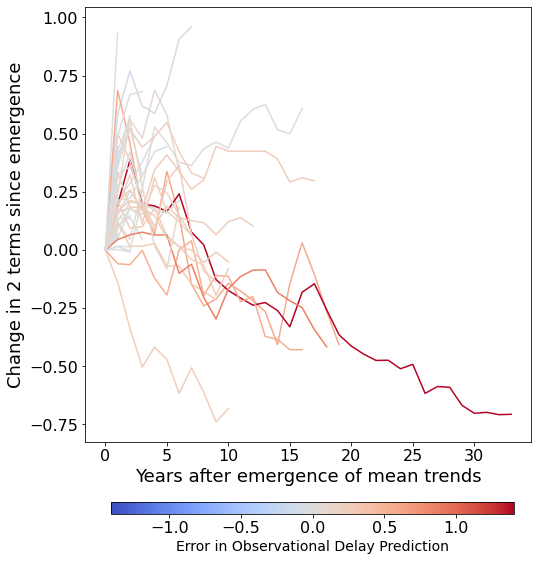

In [150]:
# Make symmetric
# min_val, max_val = min(fractional_delay_residual), max(fractional_delay_residual)
min_val, max_val = -1*max(fractional_delay_residual), max(fractional_delay_residual)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

# convert your distances to color coordinates, first applying the norm and then querying the cmap
color_list = cmap(norm(fractional_delay_residual))

fig,ax = plt.subplots(1,1,figsize=(8,8))

for _ratio_tseries,_trend_tseries,_delay_resid,_color in zip(ratios_from_emerge,
                                                             trends_from_emerge,
                                                             fractional_delay_residual,
                                                             color_list):
    
    if len(_trend_tseries) > 0:
        
        _ratio_term = _ratio_tseries - _ratio_tseries[0]
        _trend_term = (_trend_tseries - _trend_tseries[0]) / _trend_tseries[0]
        ax.plot(_trend_term - _ratio_term, color=_color)      
        
ax.set_ylabel('Change in 2 terms since emergence',fontsize=18)
ax.set_xlabel('Years after emergence of mean trends',fontsize=18)
ax.tick_params(axis='both',labelsize=16)

cbar_axh = fig.add_axes([0.17, 0.0, 0.70, 0.02])
# cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

# cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
cb = mpl.colorbar.ColorbarBase(ax=cbar_axh, 
                               cmap=cmap, 
                               norm=norm, 
                               # boundaries=[-0.2,1.4],
                               # ticks = np.arange(-0.2,1.5,0.2), 
                               orientation='horizontal')

cb.set_label('Error in Observational Delay Prediction',fontsize=14)
cbar_axh.tick_params(axis='x',labelsize=16 )#rotation=90)

# cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, ticks = sorted(distance_list), orientation='horizontal')
# cb.set_label('Distance (least to greatest)')
# ax.tick_params(axis='x', rotation=90)

## Old Code

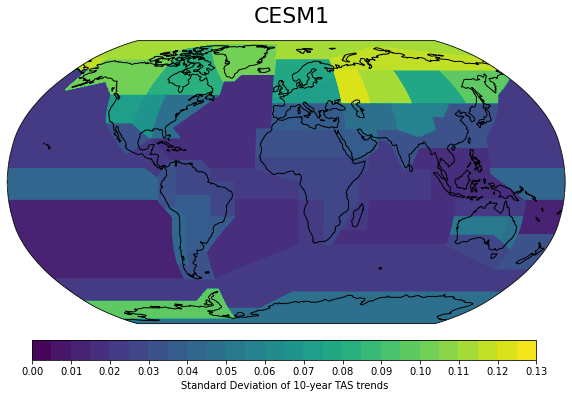

In [48]:
model_name = 'CESM1'
_unc_mask = cesm1_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

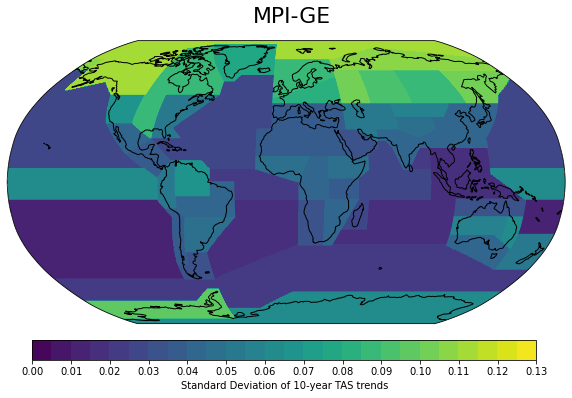

In [97]:
model_name = 'MPI-GE'
_unc_mask = mpi_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

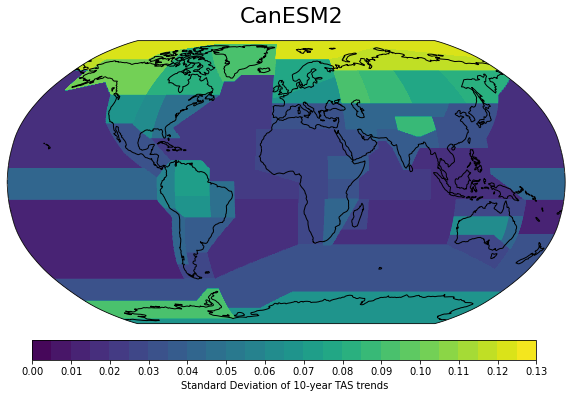

In [98]:
model_name = 'CanESM2'
_unc_mask = canesm2_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()

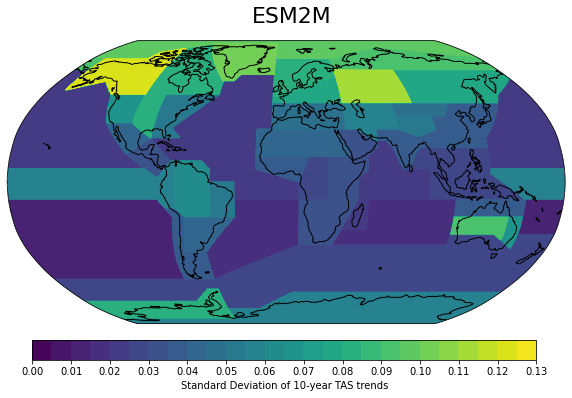

In [99]:
model_name = 'ESM2M'
_unc_mask = esm2m_unc_mask

fig = plt.figure(figsize=(10,7))

ax = plt.axes(projection=ccrs.Robinson(),)

cax = plt.axes([0.16, 0.15, 0.7, 0.04])

im = ax.contourf(_unc_mask.lon,_unc_mask.lat,_unc_mask, 60,
             transform=ccrs.PlateCarree(),levels=np.linspace(0,0.13,27))

ax.coastlines()
ax.set_global()

fig.colorbar(im,orientation='horizontal',
             ticks=np.linspace(0,0.13,14),
             label='Standard Deviation of 10-year TAS trends',
             cax=cax
            )
fig.suptitle(model_name,fontsize=22,x=0.52,y=0.85)

plt.show()